# Evaluation of parallel vs. sliding schedules with and without speculation

## Focusing on simple experiments (Idle, RegularTSchedule, and 15-to-1 distillation)

In [67]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

import dill
import numpy as np
import matplotlib.pyplot as plt

from swiper2.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule
from swiper2.simulator import DecodingSimulator
import swiper2.plot as plotter

In [56]:
d=7
decoding_latency_fn = lambda volume: volume # each round of dxd syndromes takes 1 cycle to decode (so a 2dxdxd window takes 2d cycles)
speculation_latencies = [6]
speculation_accuracies = np.linspace(0, 1, 11)
trials = 10
pending_window_count_cutoff = 100

## Idle

In [53]:
memory_schedule = MemorySchedule(100*d)
memory_ideal_duration = memory_schedule.schedule.total_duration(d)

In [12]:
load_data = True
if load_data:
    with open('notebooks/data/01_memory.pkl', 'rb') as f:
        results = dill.load(f)
        memory_data = results['memory_data']
        d = results['d']
        decoding_latency_fn = results['decoding_latency_fn']
        speculation_latencies = results['speculation_latencies']
        speculation_accuracies = results['speculation_accuracies']
        trials = results['trials']
        pending_window_count_cutoff = results['pending_window_count_cutoff']
        memory_schedule = results['schedule']
else:
    memory_data = []
    for i,speculation_latency in enumerate(speculation_latencies):
        memory_data.append([])
        for j,speculation_accuracy in enumerate(speculation_accuracies):
            memory_data[-1].append([])
            for k,trial in enumerate(range(trials)):
                print(i, j, k, end = '  ')
                simulator = DecodingSimulator(
                    distance=d,
                    decoding_latency_fn=decoding_latency_fn,
                    speculation_latency=speculation_latency,
                    speculation_accuracy=speculation_accuracy,
                    speculation_mode='separate',
                )

                success_sliding_spec, device_data_sliding_spec, window_data_sliding_spec, decoding_data_sliding_spec = simulator.run(
                    schedule=memory_schedule.schedule,
                    scheduling_method='sliding',
                    enforce_window_alignment=False,
                    max_parallel_processes=None,
                    pending_window_count_cutoff=pending_window_count_cutoff,
                )

                success_parallel_spec, device_data_parallel_spec, window_data_parallel_spec, decoding_data_parallel_spec = simulator.run(
                    schedule=memory_schedule.schedule,
                    scheduling_method='parallel',
                    enforce_window_alignment=False,
                    max_parallel_processes=None,
                    pending_window_count_cutoff=pending_window_count_cutoff,
                )

                memory_data[-1][-1].append((
                    (success_sliding_spec, device_data_sliding_spec, window_data_sliding_spec, decoding_data_sliding_spec),
                    (success_parallel_spec, device_data_parallel_spec, window_data_parallel_spec, decoding_data_parallel_spec),
                ))
    with open('notebooks/data/01_memory.pkl', 'wb') as f:
        dill.dump({
            'memory_data': memory_data,
            'd': d,
            'decoding_latency_fn': decoding_latency_fn,
            'speculation_latencies': speculation_latencies,
            'speculation_accuracies': speculation_accuracies,
            'trials': trials,
            'pending_window_count_cutoff': pending_window_count_cutoff,
            'schedule': memory_schedule,
        }, f)

0 0 0  0 0 1  0 0 2  0 0 3  0 0 4  0 0 5  0 0 6  0 0 7  0 0 8  0 0 9  0 1 0  0 1 1  0 1 2  0 1 3  0 1 4  0 1 5  0 1 6  0 1 7  0 1 8  0 1 9  0 2 0  0 2 1  0 2 2  0 2 3  0 2 4  0 2 5  0 2 6  0 2 7  0 2 8  0 2 9  0 3 0  0 3 1  0 3 2  0 3 3  0 3 4  0 3 5  0 3 6  0 3 7  0 3 8  0 3 9  0 4 0  0 4 1  0 4 2  0 4 3  0 4 4  0 4 5  0 4 6  0 4 7  0 4 8  0 4 9  0 5 0  0 5 1  0 5 2  0 5 3  0 5 4  0 5 5  0 5 6  0 5 7  0 5 8  0 5 9  0 6 0  0 6 1  0 6 2  0 6 3  0 6 4  0 6 5  0 6 6  0 6 7  0 6 8  0 6 9  0 7 0  0 7 1  0 7 2  0 7 3  0 7 4  0 7 5  0 7 6  0 7 7  0 7 8  0 7 9  0 8 0  0 8 1  0 8 2  0 8 3  0 8 4  0 8 5  0 8 6  0 8 7  0 8 8  0 8 9  0 9 0  0 9 1  0 9 2  0 9 3  0 9 4  0 9 5  0 9 6  0 9 7  0 9 8  0 9 9  0 10 0  0 10 1  0 10 2  0 10 3  0 10 4  0 10 5  0 10 6  0 10 7  0 10 8  0 10 9  

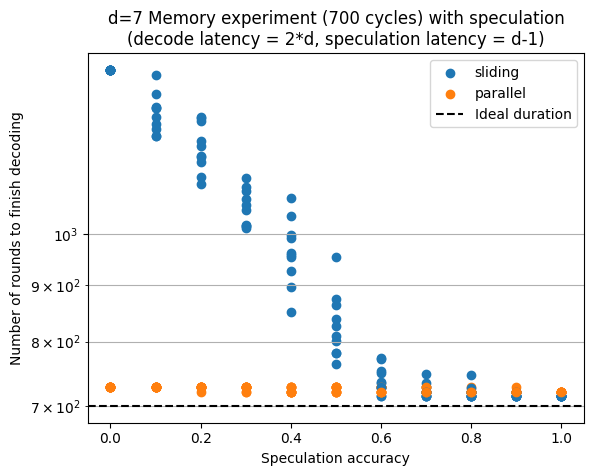

In [43]:
made_label_sliding = False
made_label_parallel = False
made_fail_label = False
for i_rev,speculation_latency in enumerate(reversed(speculation_latencies)):
    i = len(speculation_latencies) - i_rev - 1
    for j,speculation_accuracy in enumerate(speculation_accuracies):
        for k in range(trials):
            data = memory_data[i][j][k]
            if data[0][0]:
                plt.scatter([speculation_accuracy], data[0][3].num_rounds, color=f'C0', alpha=(speculation_latency+1)/(max(speculation_latencies)+1), label=('sliding' if not made_label_sliding else None))
                made_label_sliding = True
            else:
                print(f'Failed sliding speculation at {speculation_accuracy} accuracy')
            if data[1][0]:
                plt.scatter([speculation_accuracy], data[1][3].num_rounds, color=f'C1', alpha=(speculation_latency+1)/(max(speculation_latencies)+1), label=('parallel' if not made_label_parallel else None))
                made_label_parallel = True
            else:
                print(f'Failed parallel speculation at {speculation_accuracy} accuracy')

plt.axhline(memory_ideal_duration, color='k', linestyle='--', label='Ideal duration')
plt.legend()
plt.xlabel('Speculation accuracy')
plt.ylabel('Number of rounds to finish decoding')
plt.title(f'd=7 Memory experiment ({100*d} cycles) with speculation\n(decode latency = 2*d, speculation latency = d-1)')
plt.yscale('log')
plt.grid(axis='y', which='both')
plt.show()

## RegularTSchedule

In [26]:
regular_t_schedule = RegularTSchedule(10, 0)
regular_t_ideal_duration = regular_t_schedule.schedule.total_duration(d)

In [16]:
load_data = True
if load_data:
    with open('notebooks/data/01_regular_t.pkl', 'rb') as f:
        results = dill.load(f)
        regular_t_data = results['regular_t_data']
        d = results['d']
        decoding_latency_fn = results['decoding_latency_fn']
        speculation_latencies = results['speculation_latencies']
        speculation_accuracies = results['speculation_accuracies']
        trials = results['trials']
        pending_window_count_cutoff = results['pending_window_count_cutoff']
        regular_t_schedule = results['schedule']
else:
    regular_t_data = []
    for i,speculation_latency in enumerate(speculation_latencies):
        regular_t_data.append([])
        for j,speculation_accuracy in enumerate(speculation_accuracies):
            regular_t_data[-1].append([])
            for k in range(trials):
                print(i, j, k, end = '  ')
                simulator = DecodingSimulator(
                    distance=d,
                    decoding_latency_fn=decoding_latency_fn,
                    speculation_latency=speculation_latency,
                    speculation_accuracy=speculation_accuracy,
                    speculation_mode='separate',
                )

                success_sliding_spec, device_data_sliding_spec, window_data_sliding_spec, decoding_data_sliding_spec = simulator.run(
                    schedule=regular_t_schedule.schedule,
                    scheduling_method='sliding',
                    enforce_window_alignment=False,
                    max_parallel_processes=None,
                    pending_window_count_cutoff=pending_window_count_cutoff,
                )

                success_parallel_spec, device_data_parallel_spec, window_data_parallel_spec, decoding_data_parallel_spec = simulator.run(
                    schedule=regular_t_schedule.schedule,
                    scheduling_method='parallel',
                    enforce_window_alignment=False,
                    max_parallel_processes=None,
                    pending_window_count_cutoff=pending_window_count_cutoff,
                )

                regular_t_data[-1][-1].append((
                    (success_sliding_spec, device_data_sliding_spec, window_data_sliding_spec, decoding_data_sliding_spec),
                    (success_parallel_spec, device_data_parallel_spec, window_data_parallel_spec, decoding_data_parallel_spec),
                ))
    with open('notebooks/data/01_regular_t.pkl', 'wb') as f:
        dill.dump({
            'regular_t_data': regular_t_data,
            'd': d,
            'decoding_latency_fn': decoding_latency_fn,
            'speculation_latencies': speculation_latencies,
            'speculation_accuracies': speculation_accuracies,
            'trials': trials,
            'pending_window_count_cutoff': pending_window_count_cutoff,
            'schedule': regular_t_schedule,
        }, f)

0 0 0  0 0 1  0 0 2  0 0 3  0 0 4  0 0 5  0 0 6  0 0 7  0 0 8  0 0 9  0 1 0  0 1 1  0 1 2  0 1 3  0 1 4  0 1 5  0 1 6  0 1 7  0 1 8  0 1 9  0 2 0  0 2 1  0 2 2  0 2 3  0 2 4  0 2 5  0 2 6  0 2 7  0 2 8  0 2 9  0 3 0  0 3 1  0 3 2  0 3 3  0 3 4  0 3 5  0 3 6  0 3 7  0 3 8  0 3 9  0 4 0  0 4 1  0 4 2  0 4 3  0 4 4  0 4 5  0 4 6  0 4 7  0 4 8  0 4 9  0 5 0  0 5 1  0 5 2  0 5 3  0 5 4  0 5 5  0 5 6  0 5 7  0 5 8  0 5 9  0 6 0  0 6 1  0 6 2  0 6 3  0 6 4  0 6 5  0 6 6  0 6 7  0 6 8  0 6 9  0 7 0  0 7 1  0 7 2  0 7 3  0 7 4  0 7 5  0 7 6  0 7 7  0 7 8  0 7 9  0 8 0  0 8 1  0 8 2  0 8 3  0 8 4  0 8 5  0 8 6  0 8 7  0 8 8  0 8 9  0 9 0  0 9 1  0 9 2  0 9 3  0 9 4  0 9 5  0 9 6  0 9 7  0 9 8  0 9 9  0 10 0  0 10 1  0 10 2  0 10 3  0 10 4  0 10 5  0 10 6  0 10 7  0 10 8  0 10 9  

Failed sliding speculation at 0.0 accuracy
Failed sliding speculation at 0.0 accuracy
Failed sliding speculation at 0.0 accuracy
Failed sliding speculation at 0.0 accuracy
Failed sliding speculation at 0.0 accuracy
Failed sliding speculation at 0.0 accuracy
Failed sliding speculation at 0.0 accuracy
Failed sliding speculation at 0.0 accuracy
Failed sliding speculation at 0.0 accuracy
Failed sliding speculation at 0.0 accuracy
Failed sliding speculation at 0.1 accuracy
Failed sliding speculation at 0.1 accuracy
Failed sliding speculation at 0.1 accuracy
Failed sliding speculation at 0.1 accuracy
Failed sliding speculation at 0.1 accuracy
Failed sliding speculation at 0.1 accuracy
Failed sliding speculation at 0.1 accuracy
Failed sliding speculation at 0.1 accuracy
Failed sliding speculation at 0.1 accuracy
Failed sliding speculation at 0.1 accuracy
Failed sliding speculation at 0.2 accuracy
Failed sliding speculation at 0.2 accuracy
Failed sliding speculation at 0.2 accuracy
Failed slid

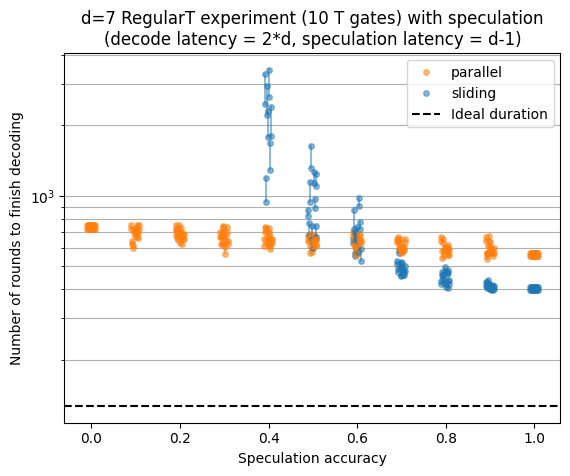

In [44]:
made_label_sliding = False
made_label_parallel = False
for i_rev,speculation_latency in enumerate(reversed(speculation_latencies)):
    i = len(speculation_latencies) - i_rev - 1
    for j,speculation_accuracy in enumerate(speculation_accuracies):
        # alpha = (speculation_latency+1)/(max(speculation_latencies)+1)
        alpha = 0.5
        for k in range(trials):
            x = speculation_accuracy
            x += 0.02 * (k - trials/2) / trials
            data = regular_t_data[i][j][k]
            if data[0][0]:
                plt.plot([x], data[0][3].num_rounds, linestyle='', marker='o', markersize=4, color=f'C0', alpha=alpha, label=('sliding' if not made_label_sliding else None))
                plt.plot([x], data[0][1].num_rounds, linestyle='', marker='o', markersize=4, color=f'C0', alpha=alpha)
                plt.plot([x,x], [data[0][1].num_rounds, data[0][3].num_rounds], color=f'C0', alpha=alpha)
                made_label_sliding = True
            else:
                print(f'Failed sliding speculation at {speculation_accuracy} accuracy')
            if data[1][0]:
                plt.plot([x], data[1][3].num_rounds, linestyle='', marker='o', markersize=4, color=f'C1', alpha=alpha, label=('parallel' if not made_label_parallel else None))
                plt.plot([x], data[1][1].num_rounds, linestyle='', marker='o', markersize=4, color=f'C1', alpha=alpha)
                plt.plot([x,x], [data[1][1].num_rounds, data[1][3].num_rounds], color=f'C1', alpha=alpha)
                made_label_parallel = True
            else:
                print(f'Failed parallel speculation at {speculation_accuracy} accuracy')
plt.axhline(regular_t_ideal_duration, color='k', linestyle='--', label='Ideal duration')
plt.legend()
plt.xlabel('Speculation accuracy')
plt.ylabel('Number of rounds to finish decoding')
plt.title(f'd=7 RegularT experiment ({10} T gates) with speculation\n(decode latency = 2*d, speculation latency = d-1)')
plt.yscale('log')
plt.grid(axis='y', which='both')
plt.show()